# Case 1: intervention analysis

In [ ]:
import pandas as pd
import numpy as np
from plotnine import * 
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as ss

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Data Processing

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/MidtermCase1Data.csv")

In [ ]:
Week = pd.concat([data.loc[:,'Week'],data.loc[:,'Week.1'],data.loc[:,'Week.2'],data.loc[:,'Week.3']],axis =0,ignore_index = True)
Sales = pd.concat([data.loc[:,'Sales'],data.loc[:,'Sales.1'],data.loc[:,'Sales.2'],data.loc[:,'Sales.3']],axis =0,ignore_index = True)

In [ ]:
d = {'Week' : Week,
     'Sales' : Sales}
data = pd.DataFrame(d)

In [ ]:
data['Abrupt'] = 0
data.loc[87:,'Abrupt'] = 1

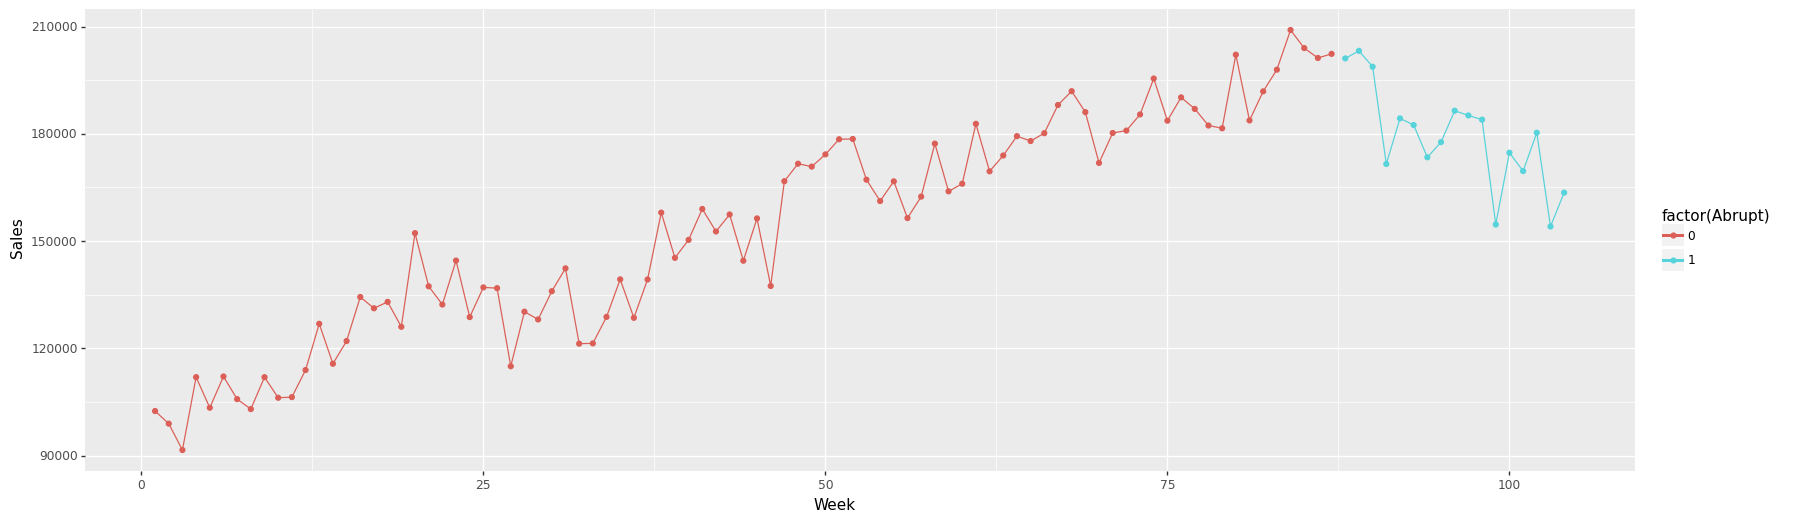

<ggplot: (8768109294657)>

In [ ]:
(
    ggplot(data,aes('Week','Sales',color='factor(Abrupt)')) + geom_point() + geom_line()+
    theme(figure_size = (20,6))
    )

We will probably need to include some lags as the data seems to have some cyclicality. 


## Regression model with lags

In [ ]:
data

,Week,Sales,Abrupt
0,1,102450,0
1,2,98930,0
2,3,91550,0
3,4,111940,0
4,5,103380,0
...,...,...,...
99,100,174720,1
100,101,169580,1
101,102,180310,1
102,103,154080,1


## The averages of sales before and after Abrupt was introduced

In [ ]:
data['M0'] = data.loc[0:86,'Sales'].mean()
data.loc[87:,'M0'] = data.loc[87:,'Sales'].mean()
data

,Week,Sales,Abrupt,M0
0,1,102450,0,153324.827586
1,2,98930,0,153324.827586
2,3,91550,0,153324.827586
3,4,111940,0,153324.827586
4,5,103380,0,153324.827586
...,...,...,...,...
99,100,174720,1,179117.058824
100,101,169580,1,179117.058824
101,102,180310,1,179117.058824
102,103,154080,1,179117.058824


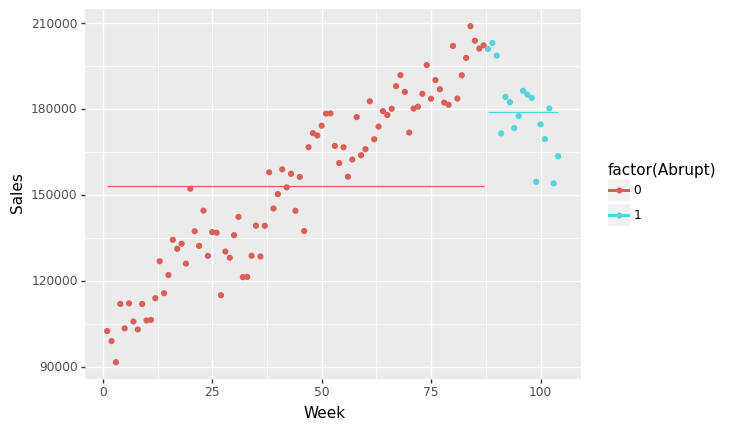

<ggplot: (8768108538909)>

In [ ]:
(
    ggplot(data,aes('Week','Sales',color='factor(Abrupt)')) + geom_point() + geom_line(aes('Week','M0'))+
    theme()
    )

In [ ]:
ss.ttest_ind(a=data.loc[:86,'Sales'],b=data.loc[87:,'Sales'],equal_var=False,alternative='greater')

Ttest_indResult(statistic=-5.409230486993325, pvalue=0.9999990983605712)

Since the p-value (1) > alpha(0.05), we conclude that the abrupt program has not effected the accidents statistically significantly.

In [ ]:
(data.loc[87:,'Sales'].mean() - data.loc[:86,'Sales'].mean()) / data.loc[:86,'Sales'].mean() *100

16.82195352401151

On average sales increased by 16.8% after the abrupt program was introduced.

## Regression model

### Model 1
Sales = b0 + b1*Abrupt = b0 before Abrupt, b0+b1 after Abrupt

Ha: Abrupt is effective -> Abrupt effects Sales (two-sided test)

In [ ]:
M1 = smf.ols('Sales ~ Abrupt',data = data).fit()

In [ ]:
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     11.58
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           0.000954
Time:                        20:35:12   Log-Likelihood:                -1213.7
No. Observations:                 104   AIC:                             2431.
Df Residuals:                     102   BIC:                             2437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.533e+05   3064.471     50.033      0.0

In [ ]:
M1.pvalues[1]

0.0009540134385735264

In [ ]:
data['M1'] = M1.fittedvalues

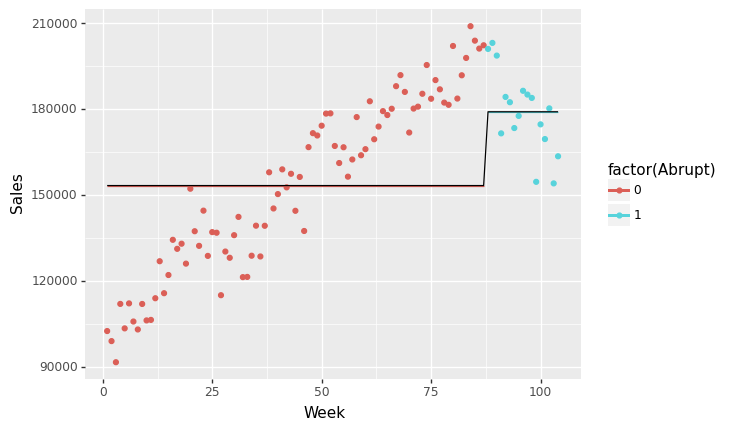

<ggplot: (8768106899573)>

In [ ]:
(
    ggplot(data,aes('Week','Sales',color='factor(Abrupt)')) + geom_point() + geom_line(aes('Week','M1'))+ 
 geom_line(aes('Week','M0'),color='black')
    )

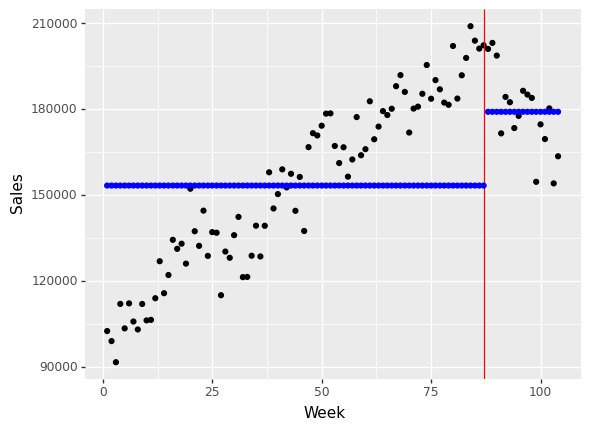

<ggplot: (8768106860429)>

In [ ]:
(
    ggplot(data, aes('Week','Sales')) +geom_point() + 
 geom_vline(xintercept=87,color='red') + geom_point(aes('Week','M1'),color='blue')
)

Although p-value(0.001) is less that critical value(0.05), which means we can reject H0, it seems that the launch of new product increases the sales of the product, which is unusual.

### Model 2
Sales = b0 + b1*Ramp

In [ ]:
data['Ramp'] = 0
data.iloc[87:,].shape
data.loc[87:,'Ramp'] = list(range(18))[1:]

In [ ]:
M2 = smf.ols('Sales ~ Ramp',data = data).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4.386
Date:                Mon, 24 Oct 2022   Prob (F-statistic):             0.0387
Time:                        20:35:14   Log-Likelihood:                -1217.1
No. Observations:                 104   AIC:                             2438.
Df Residuals:                     102   BIC:                             2443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.552e+05   3097.954     50.110      0.0

In [ ]:
M2.pvalues[1]

0.03871677164236713

Since the p-value (0.039) is less than alpha (0.05), the data provides statistically significant evidence that the effect is gradual! Sales after abrupt was introduced increases by 1566.0276 on average each week.

In [ ]:
data['M2'] = M2.fittedvalues

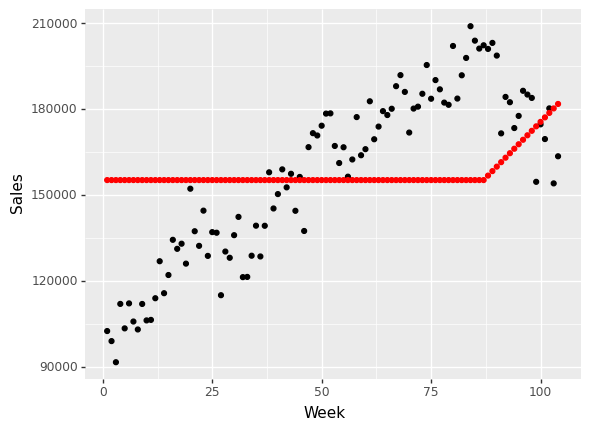

<ggplot: (8768104179709)>

In [ ]:
(
    ggplot(data, aes('Week','Sales')) + geom_point() + 
 geom_point(aes('Week','M2'),color='red')
)

### Model 3
Concluded from above models, we can find both abrupt and gradual effect on sales data.
Sales = b0 + b1*Abrupt + b2*Ramp

In [ ]:
M3 = smf.ols('Sales ~ Abrupt + Ramp',data = data).fit()
print(M3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     6.978
Date:                Mon, 24 Oct 2022   Prob (F-statistic):            0.00145
Time:                        20:35:15   Log-Likelihood:                -1212.5
No. Observations:                 104   AIC:                             2431.
Df Residuals:                     101   BIC:                             2439.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.533e+05   3046.060     50.335      0.0

In [ ]:
data['M3'] = M3.fittedvalues

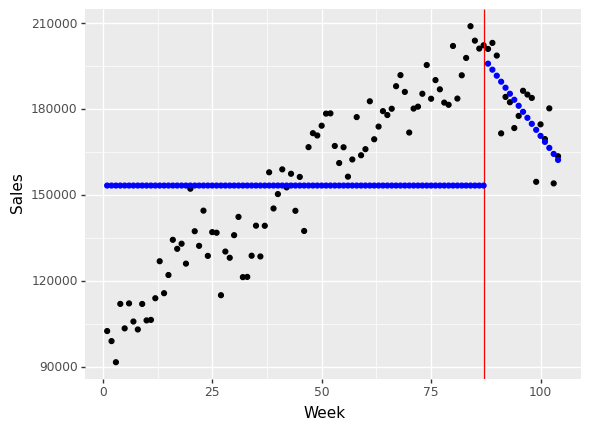

<ggplot: (8768104117821)>

In [ ]:
(
    ggplot(data, aes('Week','Sales')) +geom_point() + 
 geom_vline(xintercept=87,color='red') + geom_point(aes('Week','M3'),color='blue')
)

## Final Model

In [ ]:
data['reg1'] = 0
data['reg2'] = data.loc[:,'Week']
data['reg3'] = data.loc[:,'Abrupt']
data['reg4'] = data.loc[:,'Ramp']
M_final = smf.ols('Sales ~ reg1 + reg2 + reg3 + reg4',data=data).fit()  
print(M_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     327.8
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           1.40e-51
Time:                        20:35:16   Log-Likelihood:                -1095.4
No. Observations:                 104   AIC:                             2199.
Df Residuals:                     100   BIC:                             2209.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.026e+05   2001.719     51.248      0.0

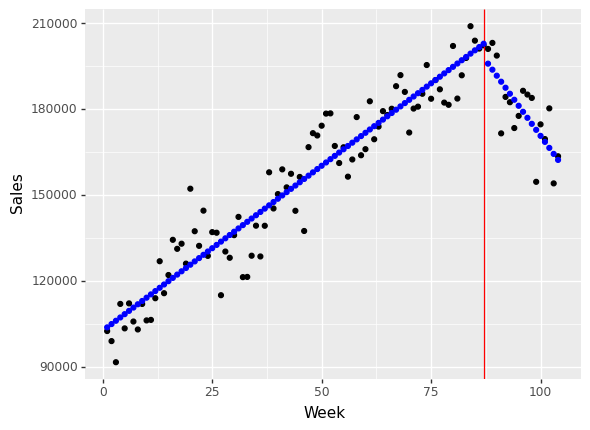

<ggplot: (8768104113485)>

In [ ]:
data['M_final'] = M_final.fittedvalues
(
    ggplot(data, aes('Week','Sales')) + geom_point() + 
 geom_vline(xintercept = 87 , color='red') + 
 geom_point(aes('Week','M_final'),color='blue') 
)

There is no statistically significant evidence to prove the following interventions the abrupt effect of the new product.

Before the new product launched, sales of the sweet potato chip was steadily increasing by 1153.1774 overall. From the graph above, we can see that new product decreased the level of sales. What's more, it had a long impact on the sales data ———— sales began to decrease by 3256.8294 weekly. So although it looks like the average of sales is higher after the launch of the new product, as time goes on, the sales data will continuously go down. 

In [ ]:
data.loc[87:,'Sales'].sum()

3044990

If there was no new product, sales = 1.026e+05 + 1153.1774*reg2, then the total sales from week88 to week104 would be 3,626,185. However, the actual sales sum is 3,044,990. The impact is 3,626,185 - 3,044,990 = 581,195.

# Case 2

In [ ]:
import pandas as pd
import numpy as np
from plotnine import *
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_datareader as pdr #read data from online data sources like FRED or Yahoo
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.model_selection import train_test_split
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
url ='https://www.census.gov/econ/currentdata/dbsearch?program=MARTS&startYear=1992&endYear=2022&categories%5B%5D=443&dataType=SM&geoLevel=US&notAdjusted=1&submit=GET+DATA&releaseScheduleId='
ScrappedPage = pd.read_html(url)
df = ScrappedPage[0]

df = df.set_index(['Year']).stack().reset_index()
df.columns = ['Year','Month','Sales']
df['MonthYear'] = [str(df['Month'][i]) + str('-') + str(df['Year'][i]) for i in range(0,len(df))]

## Plot the data and describe the patterns

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


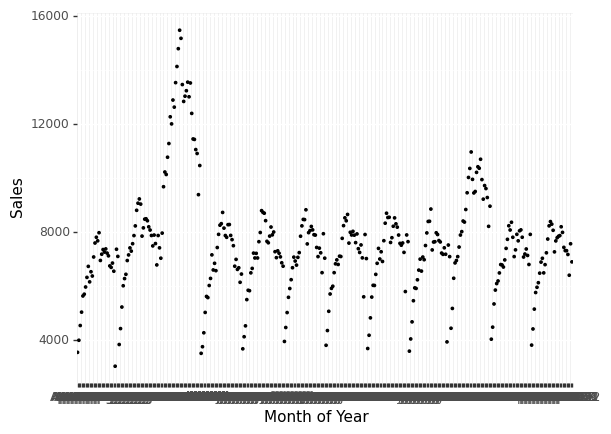

<ggplot: (8768108642585)>

In [ ]:
(
    ggplot(df, aes('MonthYear','Sales')) + geom_point(size = 0.5) + geom_line() +
    labs(x = "Month of Year", y = "Sales")
)

I saw the sales data changes regularly every year, which means there may be Cyclical(monthly) pattern. What's more, in general, sales increases every year, except two outlier years.

## Scenario 1
Training set: start = 01/1992, end=12/2016
Testing set:   start = 01/2017, end=12/2017

In [ ]:
# Accuracy Comparison Function
def rmse(actual,predicted):
    return round(((actual - predicted)**2).mean()**0.5,2)
def mape(actual,predicted):
    return round(abs((actual - predicted)/actual).mean()*100,2)
def accuracy(actual,predicted,h=0):
    n_train = len(actual) - h
    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(actual[:n_train],predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    if (h>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(actual[n_train:],predicted[n_train:])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train:],predicted[n_train:])
    return accuracy_metrics

In [ ]:
df['Trend'] = list(range(1,len(df)+1))
df['SalesBefore'] = df['Sales']

In [ ]:
df1 = df.loc[:299]

### Regression model without lags

In [ ]:
# M1: Regression model without shift for data before 12/2016
M1 = smf.ols('SalesBefore ~ Trend + C(Month)', data = df1).fit()
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     115.9
Date:                Mon, 24 Oct 2022   Prob (F-statistic):          1.91e-102
Time:                        20:35:48   Log-Likelihood:                -2450.1
No. Observations:                 300   AIC:                             4926.
Df Residuals:                     287   BIC:                             4974.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4527.7716    194.373     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


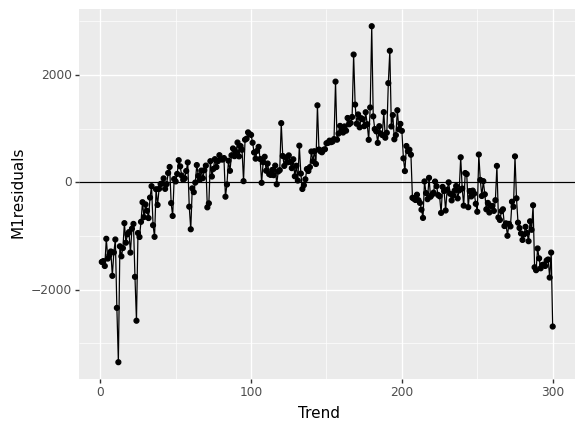

<ggplot: (8768102670297)>

In [ ]:
# Residuals have pattern, so we need to shift! 
df1['M1residuals'] = M1.resid
(
    ggplot(df1,aes('Trend','M1residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)

The graph of the residual is still not completely random noise and it seems to have a cyclical pattern. We need to use plot_acf and plot_pacf to confirm if the residual is cyclical and if so, we need to create lags to include cyclical patterns into our predictions. 

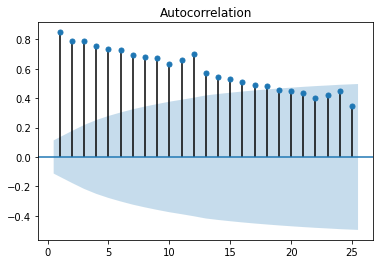

In [ ]:
# There is trend!
plot_acf(df1['M1residuals'],missing = 'drop',zero = False);

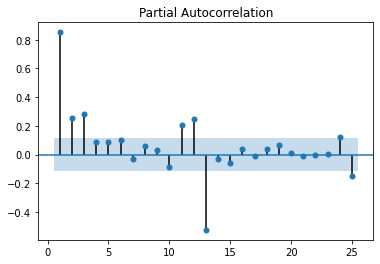

In [ ]:
# Looking at the PACF, I choose 1,2,3,11,12 to shift. 
plot_pacf(df1.loc[df1['M1residuals'].notna(),'M1residuals'], zero = False);

From the plot above, we can see that 1,2,3,11,12 lags are significant as they fall outside the 5% confidence interval. Thus, we will include the five lags in our prediction as cyclical components.

In [ ]:
df1['SalesBeforeLag1'] = df1['SalesBefore'].shift(1)
df1['SalesBeforeLag2'] = df1['SalesBefore'].shift(2)
df1['SalesBeforeLag3'] = df1['SalesBefore'].shift(3)
df1['SalesBeforeLag11'] = df1['SalesBefore'].shift(11)
df1['SalesBeforeLag12'] = df1['SalesBefore'].shift(12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Regression model with lags

In [ ]:
# M2: Regression model with cyclical component for data before 12/2016
M2 = smf.ols('SalesBefore ~ Trend + C(Month) + SalesBeforeLag1 + SalesBeforeLag2 + SalesBeforeLag3 + SalesBeforeLag11 + SalesBeforeLag12',data = df1).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     677.2
Date:                Mon, 24 Oct 2022   Prob (F-statistic):          2.98e-210
Time:                        20:35:49   Log-Likelihood:                -2048.8
No. Observations:                 288   AIC:                             4134.
Df Residuals:                     270   BIC:                             4200.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           99.6678    148.192  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


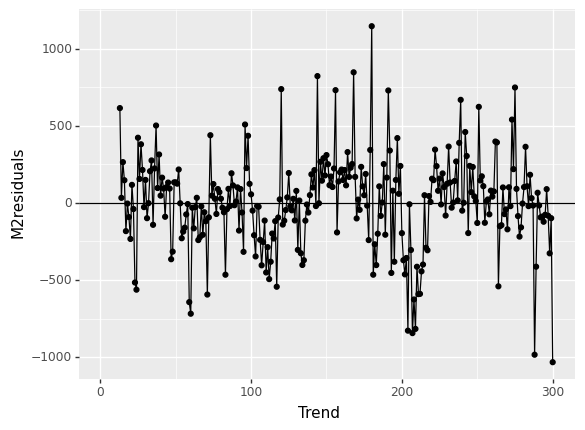

<ggplot: (8768102641037)>

In [ ]:
df1['M2'] = M2.fittedvalues
df1['M2residuals'] = M2.resid
(
    ggplot(df1,aes('Trend','M2residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)
# it is now due to noise

In [ ]:
# predict using regression model
month = ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
for i in list(range(300,312)):
    df1.loc[i,'Trend'] = i+1
    df1.loc[i,'Year'] = 2017
    df1.loc[i,'Sales'] = df.loc[i,'Sales']
    if i%12 >= 10:
        df1.loc[i,'Month'] = month[i%12-10]
    else:
        df1.loc[i,'Month'] = month[i%12+2]
    df1.loc[i,'SalesBeforeLag1'] = df1.loc[i-1,'SalesBefore']
    df1.loc[i,'SalesBeforeLag2'] = df1.loc[i-2,'SalesBefore']
    df1.loc[i,'SalesBeforeLag3'] = df1.loc[i-3,'SalesBefore']
    df1.loc[i,'SalesBeforeLag11'] = df1.loc[i-11,'SalesBefore']
    df1.loc[i,'SalesBeforeLag12'] = df1.loc[i-12,'SalesBefore']
    df1.loc[i,'SalesBefore'] = M2.predict(df1.iloc[[i]]).values
    df1.loc[i,'M2'] = M2.predict(df1.iloc[[i]]).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


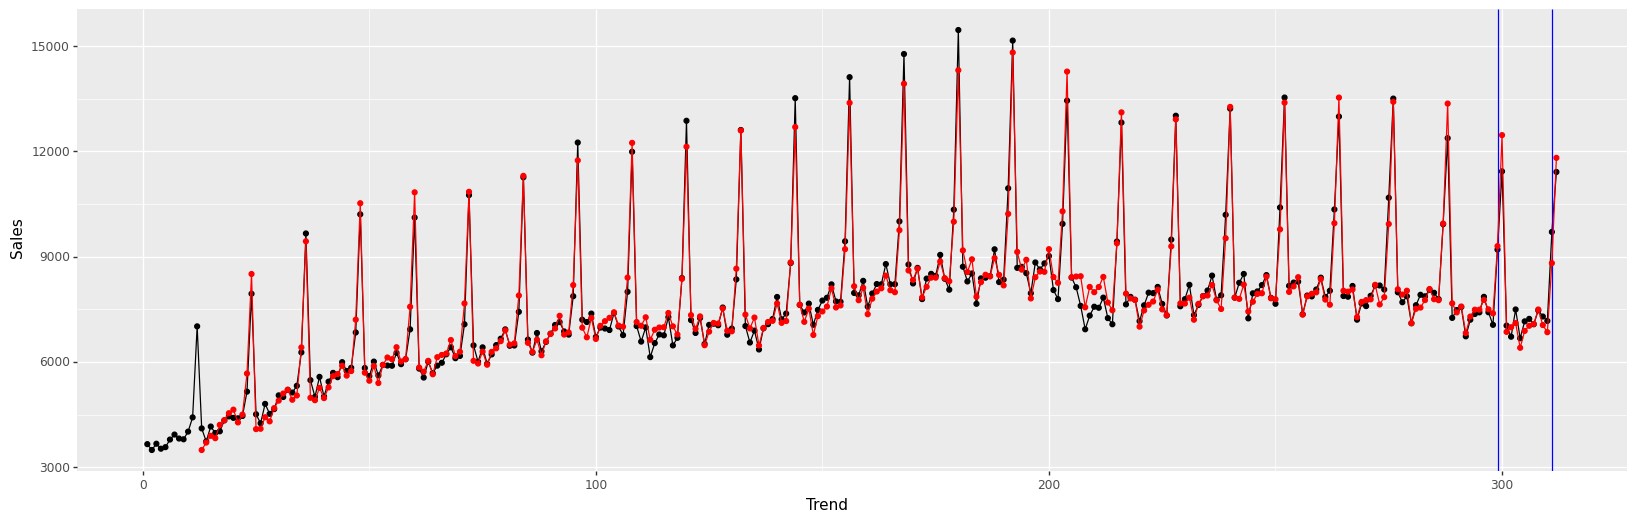

<ggplot: (8768102539065)>

In [ ]:
(
    ggplot(df1,aes('Trend','Sales')) + geom_point() + geom_line() +
 theme(figure_size = (20,6))+
 geom_vline(xintercept = 299, color ='blue', size = 0.5) + geom_vline(xintercept = 311, color='blue',size=0.5) +
 geom_point(aes('Trend','M2'), color='red') + geom_line(aes('Trend','M2'),color='red')
)

In [ ]:
accuracy(actual = df1.loc[:311,'Sales'], predicted = df1.loc[:311,'M2'],h=12)

,RMSE,MAPE(%)
Training set,297.39,2.77
Testing set,360.11,3.61


### Smoothing model

In [ ]:
M3 = ExponentialSmoothing(df.loc[:299,'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

In [ ]:
df.loc[:299,'M3'] = M3.fittedvalues

In [ ]:
df.loc[300:,'M3'] = M3.forecast(80)
df['Prediction'] = 'Fitted Values'
df.loc[300:,'Prediction'] = 'Forcast'

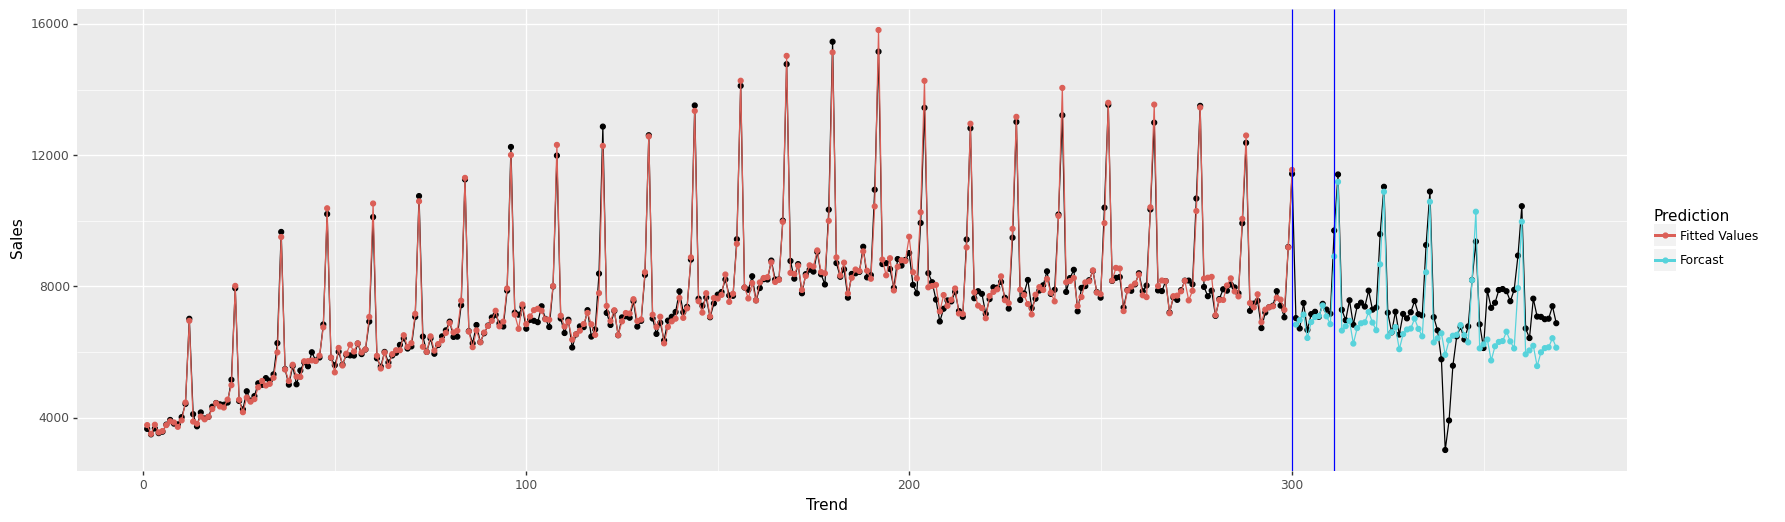

<ggplot: (8768102480669)>

In [ ]:
(
    ggplot(df,aes('Trend','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Trend','M3',color='Prediction')) + geom_line(aes('Trend','M3',color='Prediction')) +
 geom_vline(xintercept = 300, color ='blue', size = 0.5) + geom_vline(xintercept = 311, color='blue',size=0.5) + theme(figure_size = (20,6))
)

In [ ]:
accuracy(actual = df.loc[:311,'Sales'], predicted = df.loc[:311,'M3'],h=12)

,RMSE,MAPE(%)
Training set,210.39,2.0
Testing set,315.95,3.25


### Choose Smoothing model

I built a smoothing model and a time series model with cyclical components. From the RMSE and MAPE data of the two models, we can conclude that smoothing model is better. In both of the models, both RMSE and  MAPE for the testing set are more than those of the training set, which indicates that the model is a little overfit the data.
However, under the smoothing model, both RMSE and MAPE for testing and training set are less than those in time series model, which indicates that smoothing model is better. 

And the covid impact on sales data is the following:

### Covid impact in both millions of dollars and percentages

In [ ]:
# impact
round(df.loc[((df.Trend <= 341) & (df.Trend >= 339)),'Sales'].sum() - df.loc[((df.Trend <= 341) & (df.Trend >= 339)),'M3'].sum()*1000,0)

-18832117.0

In [ ]:
# %impact
(df.loc[((df.Trend <= 341) & (df.Trend >= 339)),'M3'].sum() - df.loc[((df.Trend <= 341) & (df.Trend >= 339)),'Sales'].sum()) / df.loc[((df.Trend <= 341) & (df.Trend >= 339)),'M3'].sum()

0.3258094867118932

### Predict the next 12 values

In [ ]:
# prediction from 01/2017 to 12/2017
df.loc[300:311,['Year','Trend','Month','M3']]

,Year,Trend,Month,M3
300,2017,301,Jan,6835.211387
301,2017,302,Feb,6973.734301
302,2017,303,Mar,7140.344201
303,2017,304,Apr,6427.733772
304,2017,305,May,6914.411590
305,2017,306,Jun,7064.789954
306,2017,307,Jul,7096.234170
307,2017,308,Aug,7418.640465
308,2017,309,Sep,7087.995726
309,2017,310,Oct,6848.926228


### Plot

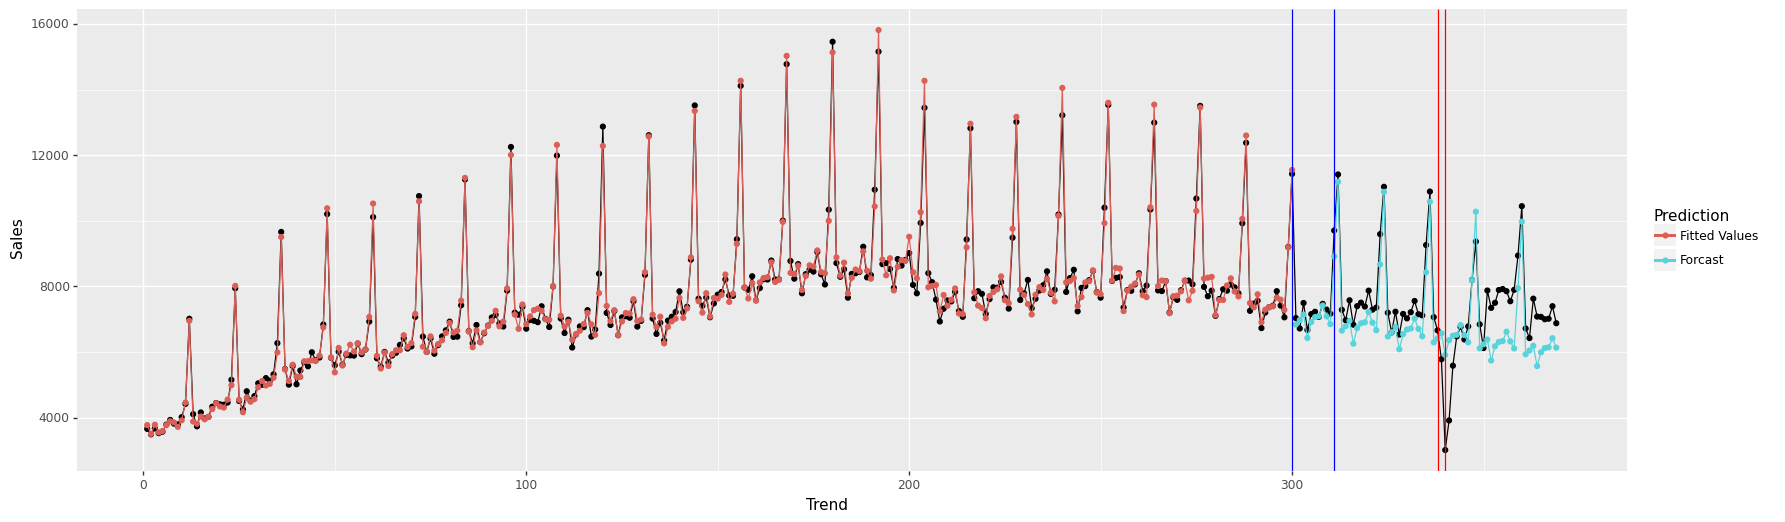

<ggplot: (8768102771333)>

In [ ]:
(
    ggplot(df,aes('Trend','Sales')) + geom_point() + geom_line()+
    geom_point(aes('Trend','M3',color='Prediction')) + geom_line(aes('Trend','M3',color='Prediction')) +
    geom_vline(xintercept = 338, color ='red', size = 0.5) + geom_vline(xintercept = 340, color='red',size=0.5) +
    geom_vline(xintercept = 300, color ='blue', size = 0.5) + geom_vline(xintercept = 311, color='blue',size=0.5) + theme(figure_size = (20,6))
)

## Scenario 2

### Regression model without lags

In [ ]:
df2 = df.loc[:311]

In [ ]:
# M4: Regression model without cyclical component for data before 12/2017
M4 = smf.ols('SalesBefore ~ Trend + C(Month)', data = df2).fit()
print(M4.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     101.1
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           1.31e-97
Time:                        20:35:52   Log-Likelihood:                -2567.3
No. Observations:                 312   AIC:                             5161.
Df Residuals:                     299   BIC:                             5209.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4664.6211    202.528     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


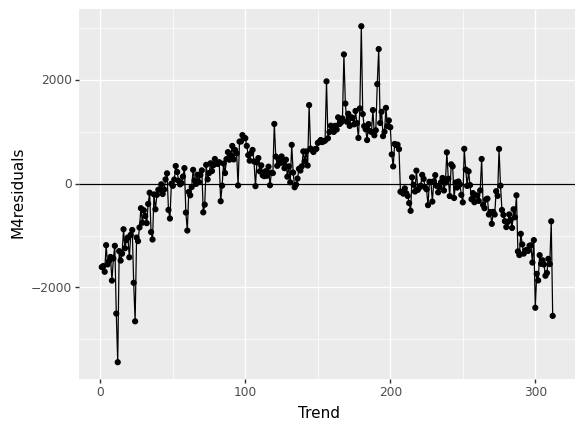

<ggplot: (8768102600025)>

In [ ]:
# Residuals have pattern, so we need to shift!
df2['M4residuals'] = M4.resid
(
    ggplot(df2,aes('Trend','M4residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)

The graph of the residual is still not completely random noise and it seems to have a cyclical pattern. We need to use plot_acf and plot_pacf to confirm if the residual is cyclical and if so, we need to create lags to include cyclical patterns into our predictions. 

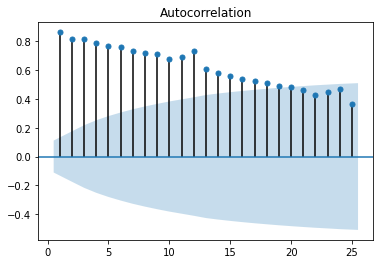

In [ ]:
# There is trend!
plot_acf(df2['M4residuals'],missing = 'drop',zero = False);

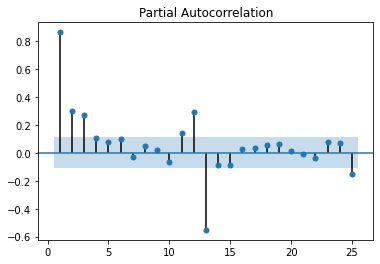

In [ ]:
# Looking at the PACF, I choose 1,2,3,11,12 to shift. 
plot_pacf(df2.loc[df2['M4residuals'].notna(),'M4residuals'], zero = False);

From the plot above, we can see that 1,2,3,11,12 lags are significant as they fall outside the 5% confidence interval. Thus, we will include the five lags in our prediction as cyclical components.

In [ ]:
df2['SalesBeforeLag1'] = df2['SalesBefore'].shift(1)
df2['SalesBeforeLag2'] = df2['SalesBefore'].shift(2)
df2['SalesBeforeLag3'] = df2['SalesBefore'].shift(3)
df2['SalesBeforeLag11'] = df2['SalesBefore'].shift(11)
df2['SalesBeforeLag12'] = df2['SalesBefore'].shift(12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Regression model with lags

In [ ]:
# M5: Regression model with cyclical component for data before 12/2017
M5 = smf.ols('SalesBefore ~ Trend + C(Month) + SalesBeforeLag1 + SalesBeforeLag2 + SalesBeforeLag3 + SalesBeforeLag11 + SalesBeforeLag12',data = df2).fit()
print(M5.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     681.2
Date:                Mon, 24 Oct 2022   Prob (F-statistic):          1.04e-217
Time:                        20:35:53   Log-Likelihood:                -2136.5
No. Observations:                 300   AIC:                             4309.
Df Residuals:                     282   BIC:                             4376.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          182.4927    141.211  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


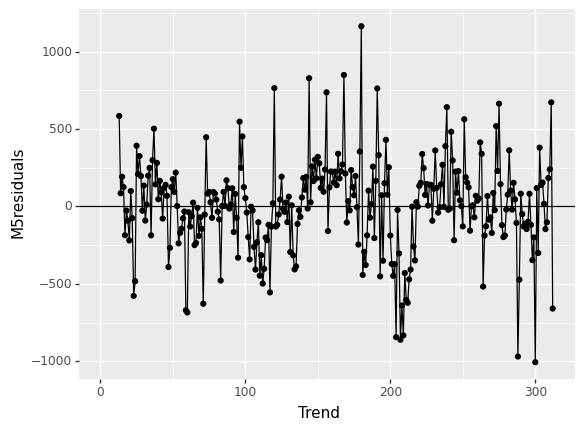

<ggplot: (8768102564665)>

In [ ]:
df2['M5'] = M5.fittedvalues
df2['M5residuals'] = M5.resid
(
    ggplot(df2,aes('Trend','M5residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)
# it is now due to noise

In [ ]:
# predict using regression model
month = ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
for i in list(range(312,324)):
    df2.loc[i,'Trend'] = i+1
    df2.loc[i,'Year'] = 2018
    df2.loc[i,'Sales'] = df.loc[i,'Sales']
    if i%12 >= 10:
        df2.loc[i,'Month'] = month[i%12-10]
    else:
        df2.loc[i,'Month'] = month[i%12+2]
    df2.loc[i,'SalesBeforeLag1'] = df2.loc[i-1,'SalesBefore']
    df2.loc[i,'SalesBeforeLag2'] = df2.loc[i-2,'SalesBefore']
    df2.loc[i,'SalesBeforeLag3'] = df2.loc[i-3,'SalesBefore']
    df2.loc[i,'SalesBeforeLag11'] = df2.loc[i-11,'SalesBefore']
    df2.loc[i,'SalesBeforeLag12'] = df2.loc[i-12,'SalesBefore']
    df2.loc[i,'SalesBefore'] = M5.predict(df2.iloc[[i]]).values
    df2.loc[i,'M5'] = M5.predict(df2.iloc[[i]]).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
accuracy(actual = df2.loc[:323,'Sales'], predicted = df2.loc[:323,'M5'],h=12)

,RMSE,MAPE(%)
Training set,299.67,2.81
Testing set,531.11,6.62


### Smoothing Model

In [ ]:
M6 = ExponentialSmoothing(df.loc[:311,'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

In [ ]:
df.loc[:311,'M6'] = M6.fittedvalues

In [ ]:
df.loc[312:,'M6'] = M3.forecast(80)
df['Prediction'] = 'Fitted Values'
df.loc[312:,'Prediction'] = 'Forcast'

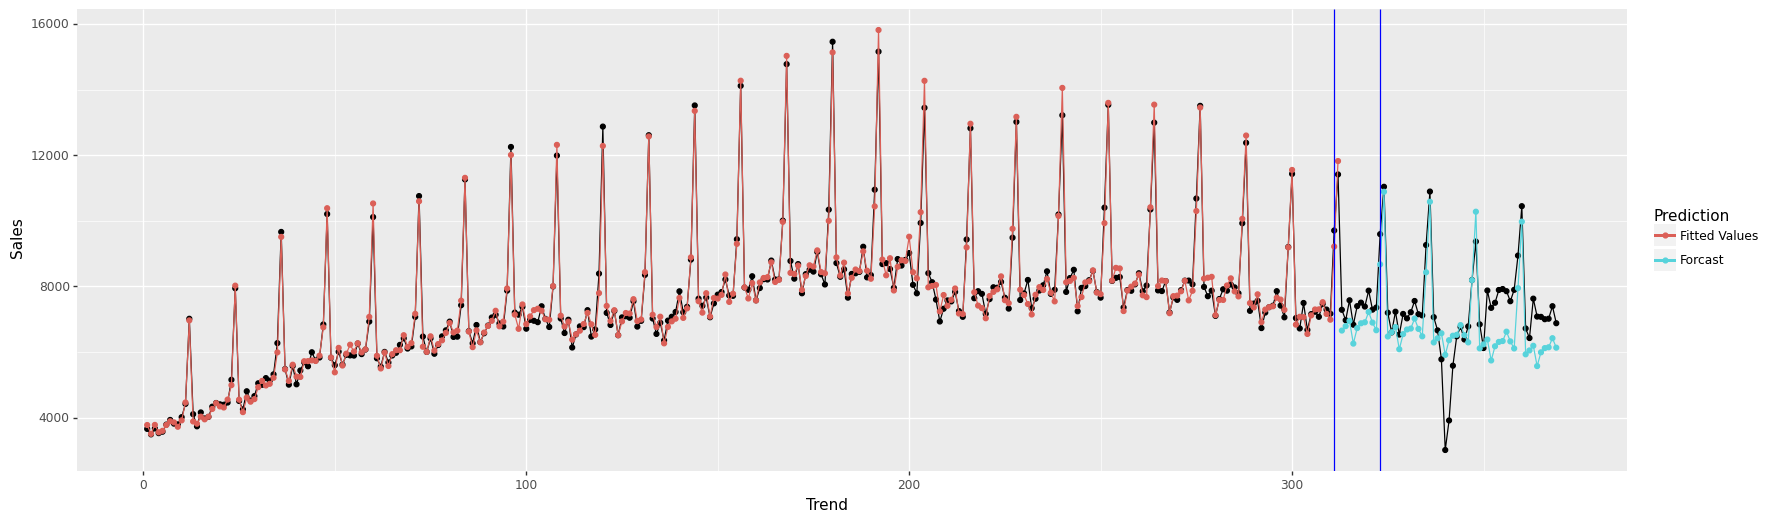

<ggplot: (8768104167197)>

In [ ]:
(
    ggplot(df,aes('Trend','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Trend','M6',color='Prediction')) + geom_line(aes('Trend','M6',color='Prediction')) +
 geom_vline(xintercept = 311, color ='blue', size = 0.5) + geom_vline(xintercept = 323, color='blue',size=0.5) + theme(figure_size = (20,6))
)

In [ ]:
accuracy(actual = df.loc[:323,'Sales'], predicted = df.loc[:323,'M6'],h=12)

,RMSE,MAPE(%)
Training set,213.07,2.03
Testing set,588.93,7.17


### Choose Regression model with lags

I built a smoothing model and a time series model with cyclical components. From the RMSE and MAPE data of the two models, we can conclude that regression model is better. In both of the models, both RMSE and MAPE for the testing set are more than those of the training set, which indicates that both models are a little overfit the data. However, under the regression model, both RMSE and MAPE for testing set are less than those in smothing model, which indicates that regression model is better.

And the covid impact on sales data is the following:

### Covid impact in both millions of dollars and percentages.

In [ ]:
# predict covid data using regression model
month = ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
for i in list(range(324,343)):
    df2.loc[i,'Trend'] = i+1
    df2.loc[i,'Sales'] = df.loc[i,'Sales']
    if i%12 >= 10:
        df2.loc[i,'Month'] = month[i%12-10]
    else:
        df2.loc[i,'Month'] = month[i%12+2]
    df2.loc[i,'SalesBeforeLag1'] = df2.loc[i-1,'SalesBefore']
    df2.loc[i,'SalesBeforeLag2'] = df2.loc[i-2,'SalesBefore']
    df2.loc[i,'SalesBeforeLag3'] = df2.loc[i-3,'SalesBefore']
    df2.loc[i,'SalesBeforeLag11'] = df2.loc[i-11,'SalesBefore']
    df2.loc[i,'SalesBeforeLag12'] = df2.loc[i-12,'SalesBefore']
    df2.loc[i,'SalesBefore'] = M5.predict(df2.iloc[[i]]).values
    df2.loc[i,'M5'] = M5.predict(df2.iloc[[i]]).values

In [ ]:
# impact
round(df2.loc[((df2.Trend <= 341) & (df2.Trend >= 339)),'Sales'].sum() - df2.loc[((df2.Trend <= 341) & (df2.Trend >= 339)),'M5'].sum()*1000,0)

-18764198.0

In [ ]:
# %impact
(df2.loc[((df2.Trend <= 341) & (df2.Trend >= 339)),'M5'].sum() - df2.loc[((df2.Trend <= 341) & (df2.Trend >= 339)),'Sales'].sum()) / df2.loc[((df2.Trend <= 341) & (df2.Trend >= 339)),'M5'].sum()

0.3233708299309498

### Predict the next 12 values

In [ ]:
# prediction from 01/2018 to 12/2018
df2.loc[312:323,['Year','Trend','Month','M5']]

,Year,Trend,Month,M5
312,2018.0,313.0,Jan,6900.715992
313,2018.0,314.0,Feb,6633.123923
314,2018.0,315.0,Mar,7026.738920
315,2018.0,316.0,Apr,6341.300806
316,2018.0,317.0,May,6813.868275
317,2018.0,318.0,Jun,6954.287548
318,2018.0,319.0,Jul,6895.154307
319,2018.0,320.0,Aug,7240.084678
320,2018.0,321.0,Sep,6909.747758
321,2018.0,322.0,Oct,6788.750067


### Plot

In [ ]:
df2['Prediction'] = 'Fitted Values'
df2.loc[312:,'Prediction'] = 'Forcast'

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


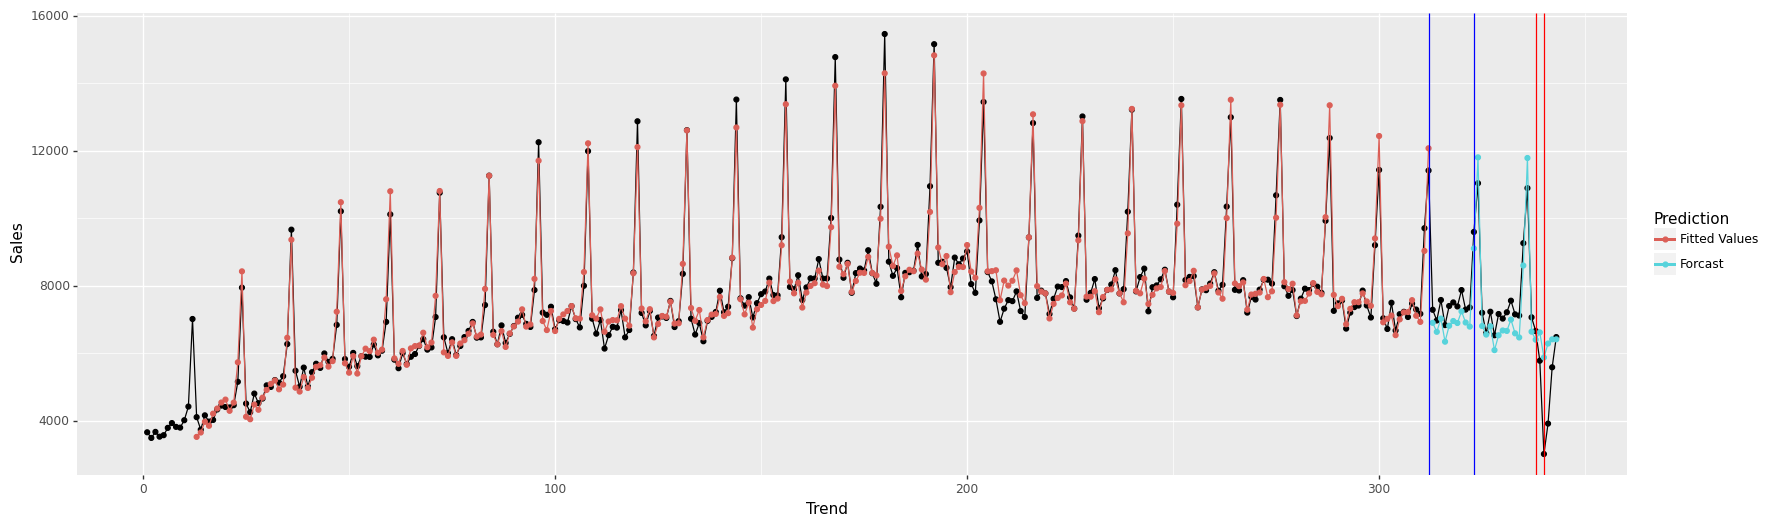

<ggplot: (8768109101505)>

In [ ]:
(
    ggplot(df2,aes('Trend','Sales')) + geom_point() + geom_line()+
    geom_point(aes('Trend','M5',color='Prediction')) + geom_line(aes('Trend','M5',color='Prediction')) +
    geom_vline(xintercept = 338, color ='red', size = 0.5) + geom_vline(xintercept = 340, color='red',size=0.5) +
    geom_vline(xintercept = 312, color ='blue', size = 0.5) + geom_vline(xintercept = 323, color='blue',size=0.5) + theme(figure_size = (20,6))
)

## Scenario 3

### Regression model without lags

In [ ]:
df3 = df.loc[:323]

In [ ]:
# M7: Regression model without cyclical component for data before 12/2018
M7 = smf.ols('SalesBefore ~ Trend + C(Month)', data = df3).fit()
print(M7.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     93.27
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           2.23e-95
Time:                        20:35:57   Log-Likelihood:                -2677.5
No. Observations:                 324   AIC:                             5381.
Df Residuals:                     311   BIC:                             5430.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4778.5906    205.747     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


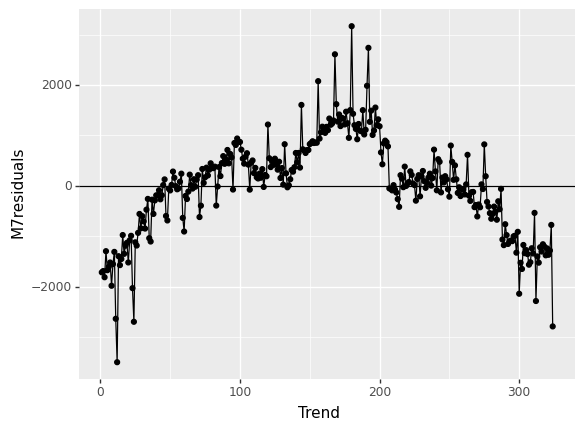

<ggplot: (8768102644877)>

In [ ]:
# Residuals have pattern, we need cyclical component. 
df3['M7residuals'] = M7.resid
(
    ggplot(df3,aes('Trend','M7residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)

The graph of the residual is still not completely random noise and it seems to have a cyclical pattern. We need to use plot_acf and plot_pacf to confirm if the residual is cyclical and if so, we need to create lags to include cyclical patterns into our predictions. 

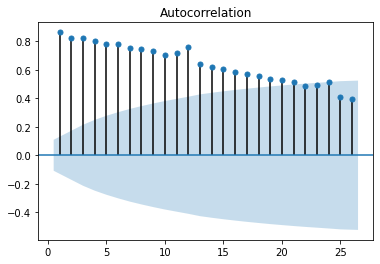

In [ ]:
# There is trend!
plot_acf(df3['M7residuals'],missing = 'drop',zero = False);

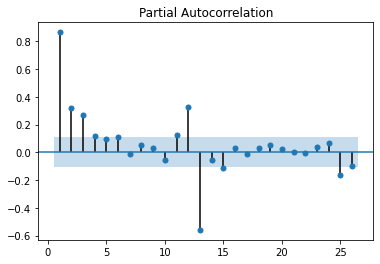

In [ ]:
# Looking at the PACF, I choose 1,2,3,12 to shift. 
plot_pacf(df3.loc[df3['M7residuals'].notna(),'M7residuals'], zero = False);

From the plot above, we can see that 1,2,3,12 lags are significant as they fall outside the 5% confidence interval. Thus, we will include the five lags in our prediction as cyclical components.

In [ ]:
df3['SalesBeforeLag1'] = df3['SalesBefore'].shift(1)
df3['SalesBeforeLag2'] = df3['SalesBefore'].shift(2)
df3['SalesBeforeLag3'] = df3['SalesBefore'].shift(3)
df3['SalesBeforeLag12'] = df3['SalesBefore'].shift(12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Regression model with lags

In [ ]:
# M8: Regression model with cyclical component for data before 12/2018
M8 = smf.ols('SalesBefore ~ Trend + C(Month) + SalesBeforeLag1 + SalesBeforeLag2 + SalesBeforeLag3 + SalesBeforeLag12',data = df3).fit()
print(M8.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     712.8
Date:                Mon, 24 Oct 2022   Prob (F-statistic):          5.33e-225
Time:                        20:35:58   Log-Likelihood:                -2227.3
No. Observations:                 312   AIC:                             4489.
Df Residuals:                     295   BIC:                             4552.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          235.7686    137.935  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


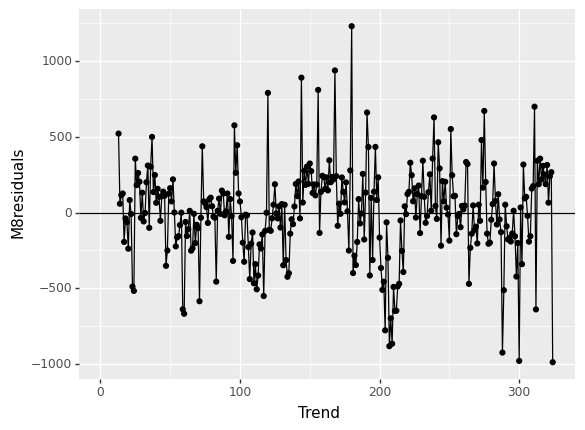

<ggplot: (8768102311897)>

In [ ]:
df3['M8'] = M8.fittedvalues
df3['M8residuals'] = M8.resid
(
    ggplot(df3,aes('Trend','M8residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)
# it is now due to noise

In [ ]:
# predict using regression model
month = ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
for i in list(range(324,336)):
    df3.loc[i,'Trend'] = i+1
    df3.loc[i,'Year'] = 2019
    df3.loc[i,'Sales'] = df.loc[i,'Sales']
    if i%12 >= 10:
        df3.loc[i,'Month'] = month[i%12-10]
    else:
        df3.loc[i,'Month'] = month[i%12+2]
    df3.loc[i,'SalesBeforeLag1'] = df3.loc[i-1,'SalesBefore']
    df3.loc[i,'SalesBeforeLag2'] = df3.loc[i-2,'SalesBefore']
    df3.loc[i,'SalesBeforeLag3'] = df3.loc[i-3,'SalesBefore']
    df3.loc[i,'SalesBeforeLag12'] = df3.loc[i-12,'SalesBefore']
    df3.loc[i,'SalesBefore'] = M8.predict(df3.iloc[[i]]).values
    df3.loc[i,'M8'] = M8.predict(df3.iloc[[i]]).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
accuracy(actual = df3.loc[:335,'Sales'], predicted = df3.loc[:335,'M8'],h=12)

,RMSE,MAPE(%)
Training set,304.85,2.84
Testing set,251.0,1.86


### Smoothing model

In [ ]:
M9 = ExponentialSmoothing(df.loc[:323,'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

In [ ]:
df.loc[:323,'M9'] = M9.fittedvalues

In [ ]:
df.loc[324:,'M9'] = M3.forecast(80)
df['Prediction'] = 'Fitted Values'
df.loc[324:,'Prediction'] = 'Forcast'

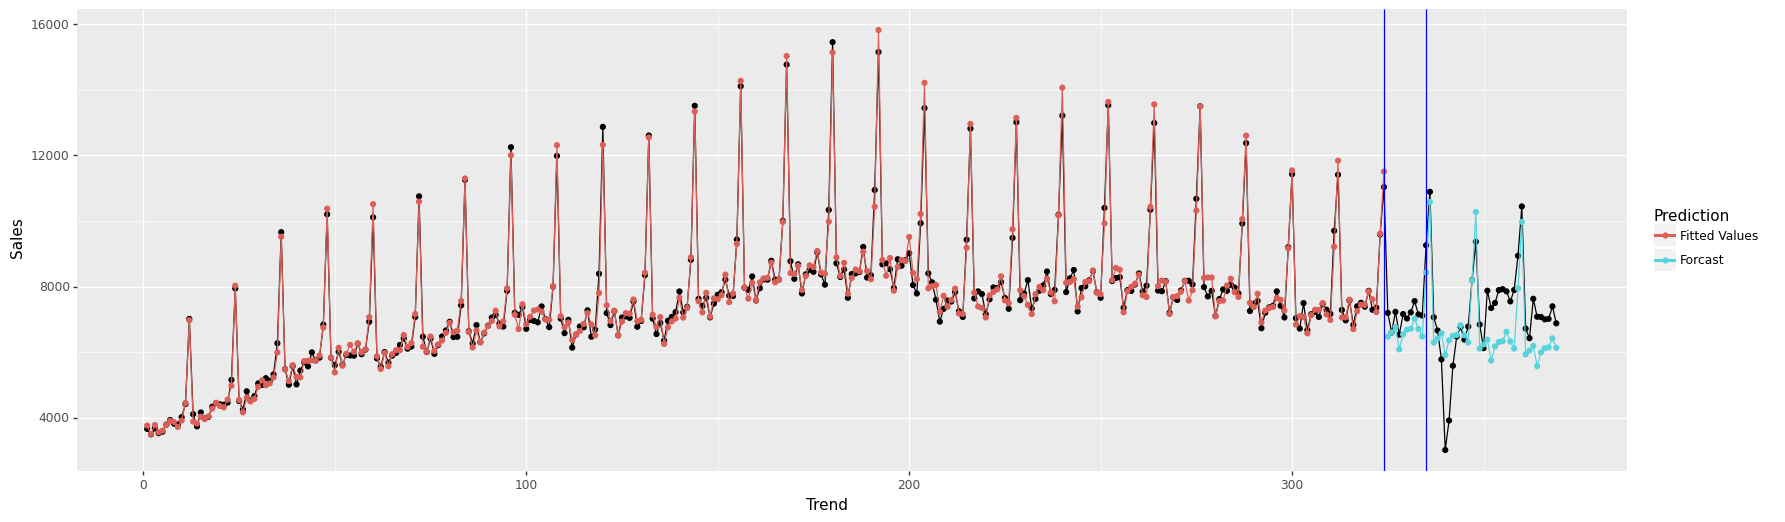

<ggplot: (8768106826597)>

In [ ]:
(
    ggplot(df,aes('Trend','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Trend','M9',color='Prediction')) + geom_line(aes('Trend','M9',color='Prediction')) +
 geom_vline(xintercept = 324, color ='blue', size = 0.5) + geom_vline(xintercept = 335, color='blue',size=0.5) + theme(figure_size = (20,6))
)

In [ ]:
accuracy(actual = df.loc[:335,'Sales'], predicted = df.loc[:335,'M9'],h=12)

,RMSE,MAPE(%)
Training set,212.12,2.02
Testing set,529.4,6.49


### Choose regression model with lags

I built a smoothing model and a time series model with cyclical components. From the RMSE and MAPE data of the two models, we can conclude that regression model is better. In the regression model, both RMSE and MAPE for the testing set are more than those of the training set, which indicates that the model doesn't overfit the data. What's more, under the regression model, both RMSE and MAPE for testing set are less than those in smoothing model, which indicates that regression model is better.

And the covid impact on sales data is the following:

In [ ]:
# predict covid data using regression model
month = ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
for i in list(range(335,343)):
    df3.loc[i,'Trend'] = i+1
    df3.loc[i,'Sales'] = df.loc[i,'Sales']
    if i%12 >= 10:
        df3.loc[i,'Month'] = month[i%12-10]
    else:
        df3.loc[i,'Month'] = month[i%12+2]
    df3.loc[i,'SalesBeforeLag1'] = df3.loc[i-1,'SalesBefore']
    df3.loc[i,'SalesBeforeLag2'] = df3.loc[i-2,'SalesBefore']
    df3.loc[i,'SalesBeforeLag3'] = df3.loc[i-3,'SalesBefore']
    df3.loc[i,'SalesBeforeLag12'] = df3.loc[i-12,'SalesBefore']
    df3.loc[i,'SalesBefore'] = M8.predict(df3.iloc[[i]]).values
    df3.loc[i,'M8'] = M8.predict(df3.iloc[[i]]).values

### Covid impact in both millions of dollars and percentages.

In [ ]:
round(df3.loc[((df3.Trend <= 341) & (df3.Trend >= 339)),'Sales'].sum() - df3.loc[((df3.Trend <= 341) & (df3.Trend >= 339)),'M8'].sum()*1000,0)

-19907101.0

In [ ]:
(df3.loc[((df3.Trend <= 341) & (df3.Trend >= 339)),'M8'].sum() - df3.loc[((df3.Trend <= 341) & (df3.Trend >= 339)),'Sales'].sum()) / df3.loc[((df3.Trend <= 341) & (df3.Trend >= 339)),'M8'].sum()

0.36219257912412733

In [ ]:
# prediction from 01/2019 to 12/2019
df3.loc[324:335,['Year','Trend','Month','M8']]

,Year,Trend,Month,M8
324,2019.0,325.0,Jan,6970.317543
325,2019.0,326.0,Feb,6759.585867
326,2019.0,327.0,Mar,7119.127425
327,2019.0,328.0,Apr,6509.733122
328,2019.0,329.0,May,7041.334346
329,2019.0,330.0,Jun,7203.319071
330,2019.0,331.0,Jul,7188.932187
331,2019.0,332.0,Aug,7619.716537
332,2019.0,333.0,Sep,7095.398160
333,2019.0,334.0,Oct,7094.829450


### Plot

In [ ]:
df3['Prediction'] = 'Fitted Values'
df3.loc[324:,'Prediction'] = 'Forcast'

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


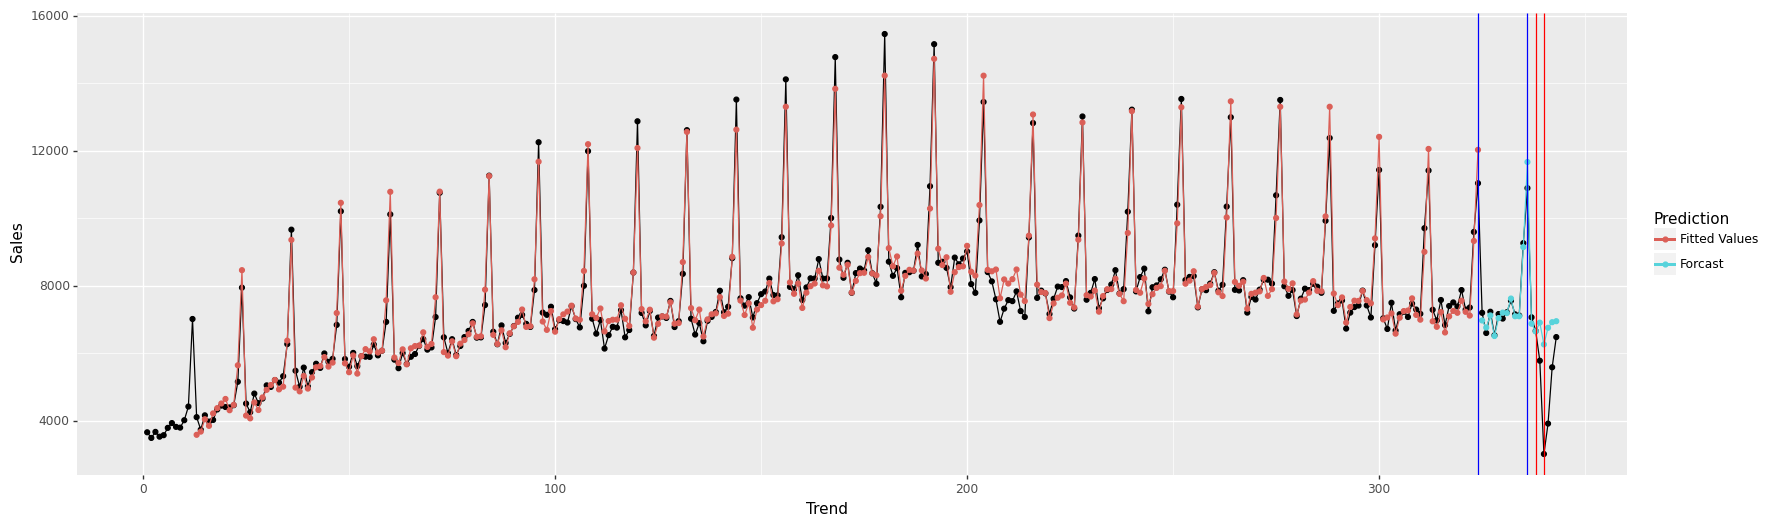

<ggplot: (8768102236181)>

In [ ]:
(
    ggplot(df3,aes('Trend','Sales')) + geom_point() + geom_line()+
    geom_point(aes('Trend','M8',color='Prediction')) + geom_line(aes('Trend','M8',color='Prediction')) +
    geom_vline(xintercept = 338, color ='red', size = 0.5) + geom_vline(xintercept = 340, color='red',size=0.5) +
    geom_vline(xintercept = 324, color ='blue', size = 0.5) + geom_vline(xintercept = 336, color='blue',size=0.5) + theme(figure_size = (20,6))
)

## Using both regression and smoothing models predict the next 12 values.

### Regression model wihtou lags

In [ ]:
# M10: Regression model without shift for all data
M10 = smf.ols('SalesBefore ~ Trend + C(Month)', data = df).fit()
print(M10.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     61.04
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           9.15e-79
Time:                        20:36:01   Log-Likelihood:                -3112.0
No. Observations:                 369   AIC:                             6250.
Df Residuals:                     356   BIC:                             6301.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5169.6904    227.582     

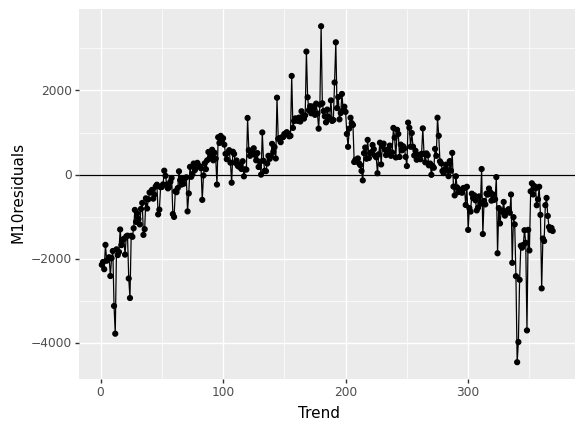

<ggplot: (8768102154145)>

In [ ]:
# Residuals have pattern, so we need to shift! 
df['M10residuals'] = M10.resid
(
    ggplot(df,aes('Trend','M10residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)

The graph of the residual is still not completely random noise and it seems to have a cyclical pattern. We need to use plot_acf and plot_pacf to confirm if the residual is cyclical and if so, we need to create lags to include cyclical patterns into our predictions. 

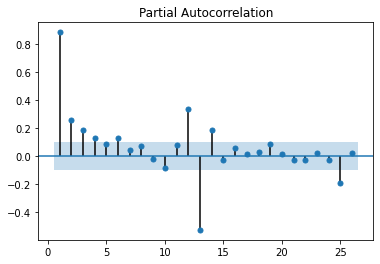

In [ ]:
# Looking at the PACF, I choose 1,2,3,12 to shift. 
plot_pacf(df.loc[df['M10residuals'].notna(),'M10residuals'], zero = False);

### Regression model with lags

In [ ]:
df['SalesBeforeLag1'] = df['SalesBefore'].shift(1)
df['SalesBeforeLag2'] = df['SalesBefore'].shift(2)
df['SalesBeforeLag3'] = df['SalesBefore'].shift(3)
df['SalesBeforeLag12'] = df['SalesBefore'].shift(12)

In [ ]:
# M11: Regression model with cyclical component for all data
M11 = smf.ols('SalesBefore ~ Trend + C(Month) + SalesBeforeLag1 + SalesBeforeLag2 + SalesBeforeLag3 + SalesBeforeLag12',data = df).fit()
print(M11.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     399.3
Date:                Mon, 24 Oct 2022   Prob (F-statistic):          2.71e-209
Time:                        20:36:02   Log-Likelihood:                -2661.7
No. Observations:                 357   AIC:                             5357.
Df Residuals:                     340   BIC:                             5423.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           96.3049    162.897  

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


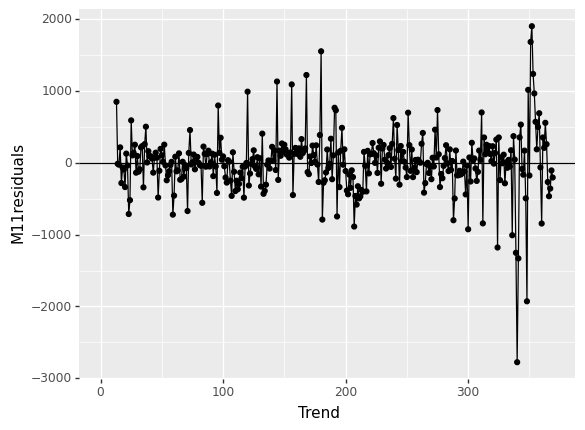

<ggplot: (8768102145089)>

In [ ]:
df['M11'] = M11.fittedvalues
df['M11residuals'] = M11.resid
(
    ggplot(df,aes('Trend','M11residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)
# it is now due to noise

In [ ]:
# predict using regression model
month = ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
for i in list(range(368,380)):
    df.loc[i,'Trend'] = i+1
    if i%12 >= 10:
        df.loc[i,'Month'] = month[i%12-10]
    else:
        df.loc[i,'Month'] = month[i%12+2]
    df.loc[i,'SalesBeforeLag1'] = df.loc[i-1,'SalesBefore']
    df.loc[i,'SalesBeforeLag2'] = df.loc[i-2,'SalesBefore']
    df.loc[i,'SalesBeforeLag3'] = df.loc[i-3,'SalesBefore']
    df.loc[i,'SalesBeforeLag12'] = df.loc[i-12,'SalesBefore']
    df.loc[i,'SalesBefore'] = M11.predict(df.iloc[[i]]).values
    df.loc[i,'M11'] = M11.predict(df.iloc[[i]]).values

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


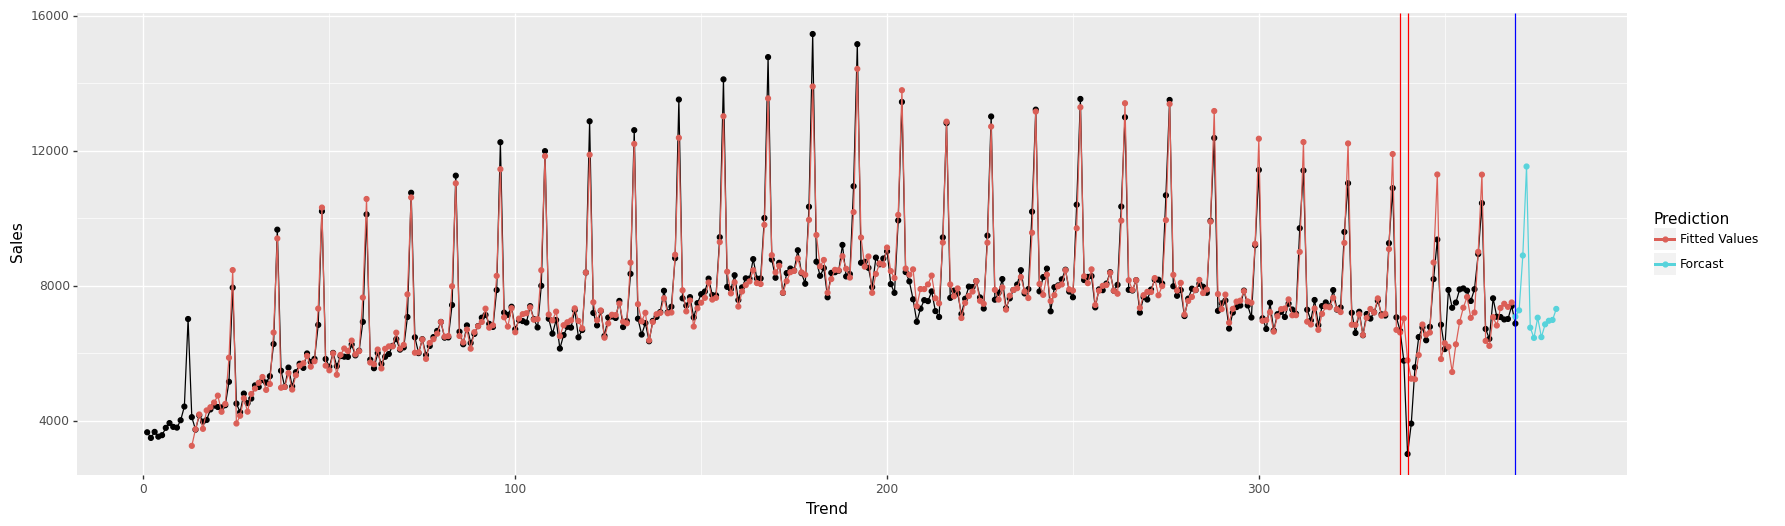

<ggplot: (8768104136081)>

In [ ]:
# plot
df['Prediction'] = 'Fitted Values'
df.loc[368:,'Prediction'] = 'Forcast'
(
    ggplot(df,aes('Trend','Sales')) + geom_point() + geom_line()+
    geom_point(aes('Trend','M11',color='Prediction')) + geom_line(aes('Trend','M11',color='Prediction')) +
    geom_vline(xintercept = 338, color ='red', size = 0.5) + geom_vline(xintercept = 340, color='red',size=0.5) +
    geom_vline(xintercept = 369, color ='blue', size = 0.5) + theme(figure_size = (20,6))
)

### Smoothing model

In [ ]:
M12 = ExponentialSmoothing(df.loc[:367,'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [ ]:
df.loc[:,'M12'] = M12.fittedvalues

In [ ]:
df.loc[368:,'M12'] = M12.forecast(12)
df['Prediction'] = 'Fitted Values'
df.loc[368:,'Prediction'] = 'Forcast'

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


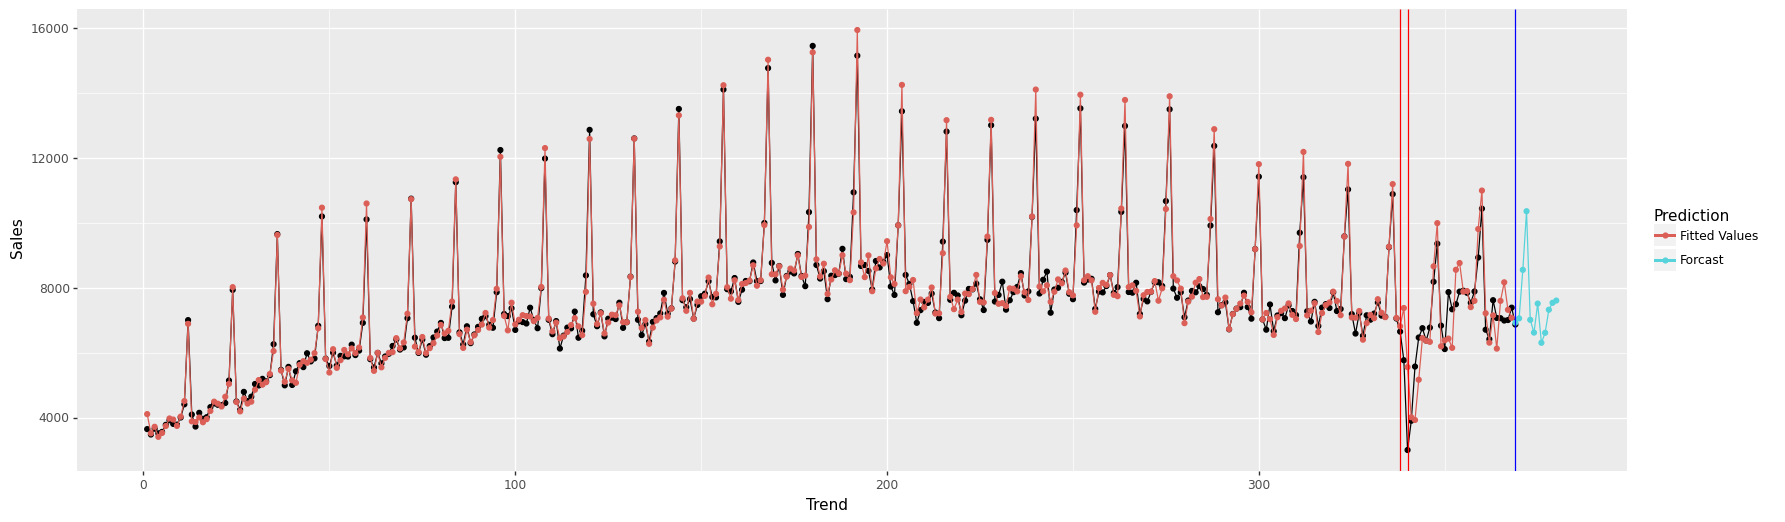

<ggplot: (8768102511409)>

In [ ]:
# plot
(
    ggplot(df,aes('Trend','Sales')) + geom_point() + geom_line()+
    geom_point(aes('Trend','M12',color='Prediction')) + geom_line(aes('Trend','M12',color='Prediction')) +
    geom_vline(xintercept = 338, color ='red', size = 0.5) + geom_vline(xintercept = 340, color='red',size=0.5) +
    geom_vline(xintercept = 369, color ='blue', size = 0.5) + theme(figure_size = (20,6))
)

### Print forecast values

In [ ]:
df.loc[368:,['Month','Trend','M11','M12']]

,Month,Trend,M11,M12
368,Sep,369.0,7082.620352,6934.763729
369,Oct,370.0,7270.022934,7066.991587
370,Nov,371.0,8895.435707,8561.590656
371,Dec,372.0,11532.861538,10366.589976
372,Jan,373.0,6756.364540,7021.452875
373,Feb,374.0,6453.657087,6628.749568
374,Mar,375.0,7052.219135,7523.350259
375,Apr,376.0,6475.742772,6315.459393
376,May,377.0,6855.854160,6622.377540
377,Jun,378.0,6961.558350,7333.611625


## Do you consider that your modeling approach presents an accurate picture of current and future data patterns?

I don't think my modeling approach presents an accurate picture of current and future data patterns.
The model forecasts the future trend purly from a statistic standpoint, where it depends its future value on the most recent previous values (due to the three most recent lags that we created). However, this could distort the predicted data immediately following the covid period as they are affected by the data during covid, which are abnormally low. As the data during covid is not part of a sustainable trend but rather only the result of a disruptive economic period, the weight we assign to the data during covid should be evaluated to be different from that of other non-covid periods. Moreover, a better modeling should take into consideration the social factors and economic incentives as well. For example, a large number of food and retail companies are taking an aggressive move in offering discounts in order to decrease inventory. Those are the social factors that our model also needs to incorporate to improve its practicability. 

# Extra credit question 1

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn import metrics

import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingRegressor

In [ ]:
df1 = pd.get_dummies(df1,prefix='',prefix_sep='',columns=['Month'])

In [ ]:
y = df1.loc[:311,'Sales']
X = df1.loc[:311,'Feb':'Sep']

In [ ]:
# define train and test data set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 12, shuffle = False)

In [ ]:
M3 =  DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, 
                          min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                          random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
M3.fit(X_train,y_train)
df1['M3'] = M3.predict(X)
# evaluate model's performance
accuracy(df1['Sales'],M3.predict(X),h=12)

,RMSE,MAPE(%)
Training set,1896.07,21.21
Testing set,1102.12,8.62


In [ ]:
M3.score(X_test, y_test)

0.3289437436771978

In [ ]:
# R^2 on the trainng and testing sets?
print(metrics.r2_score(y_train, M3.predict(X_train)))
print(metrics.r2_score(y_test, M3.predict(X_test)))

0.15379207818823026
0.3289437436771978


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


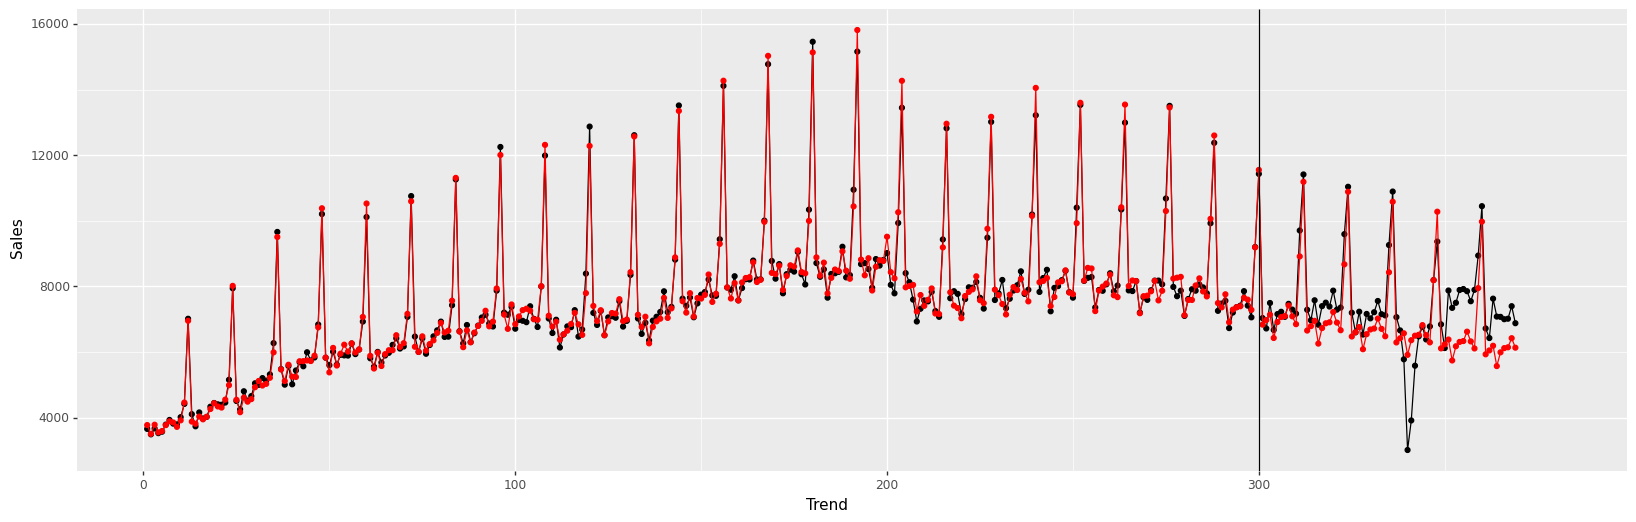

<ggplot: (8768101385421)>

In [146]:
(
    ggplot(df,aes('Trend','Sales')) + geom_point() + geom_line() +
    geom_point(aes('Trend','M3'),color='red') + geom_line(aes('Trend','M3'),color='red')+
    geom_vline(xintercept = 300) +
    theme(figure_size = (20,6))
)

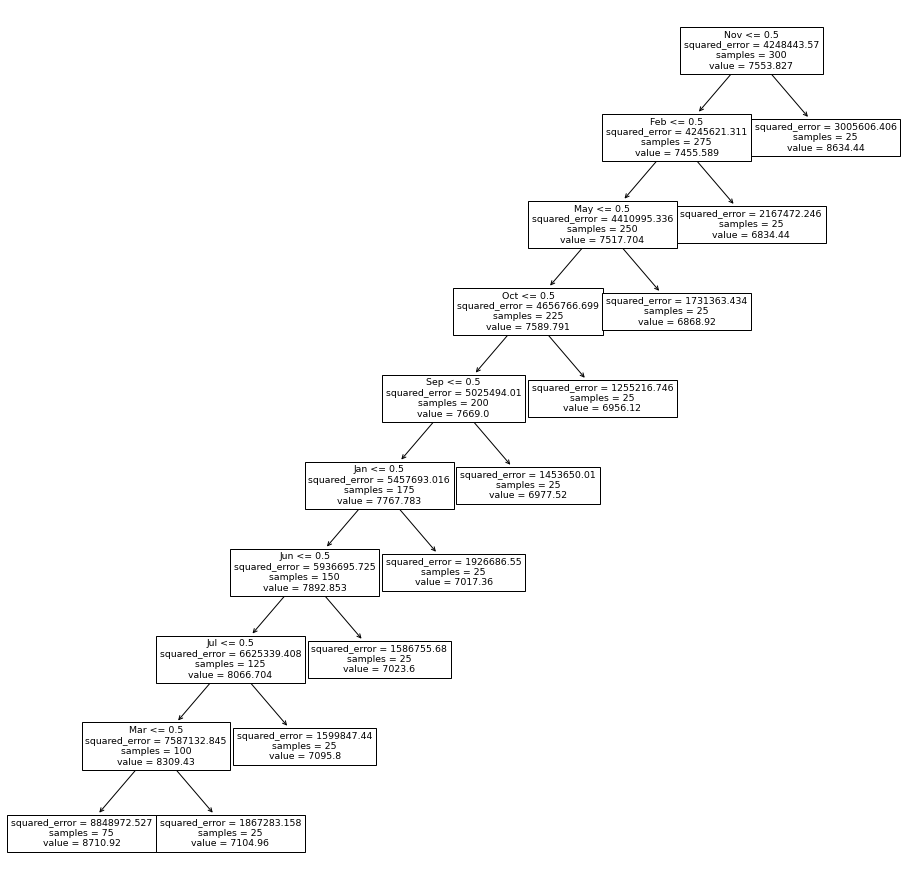

In [147]:
# show a tree
plt.figure(figsize=(16,16))
tree.plot_tree(M3,feature_names = X.columns);

In [148]:
# tune model parameters
max_depths = range(1,12+1)
training_errors = []
testing_errors = []

for i in max_depths:
    M = DecisionTreeRegressor(max_depth=i)
    M.fit(X_train,y_train)
    training_errors.append(metrics.mean_squared_error(y_train, M.predict(X_train),squared=False))
    testing_errors.append(metrics.mean_squared_error(y_test, M.predict(X_test),squared=False))
print(training_errors)
print(testing_errors)

[2035.2608520181325, 2026.5535607824431, 2016.9147720732792, 2007.5609353973127, 1996.1871979589584, 1982.426327822662, 1963.2763456766174, 1938.1075368427487, 1896.0660864713197, 1896.0660864713197, 1896.0660864713197, 1896.0660864713197]
[1242.920385319359, 1220.2003376276646, 1214.2876552118942, 1206.2021295509858, 1202.373705174576, 1180.3317044514788, 1163.2670910729544, 1122.007928804427, 1102.1193049756455, 1102.1193049756455, 1102.1193049756455, 1102.1193049756455]


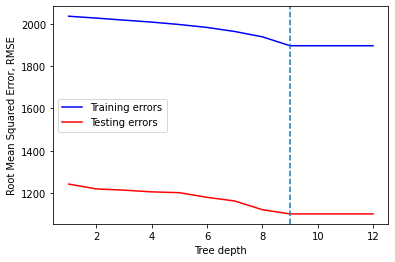

In [ ]:
plt.plot(max_depths,training_errors,color='blue',label='Training errors')
plt.plot(max_depths,testing_errors,color='red',label='Testing errors')
plt.xlabel('Tree depth')
plt.ylabel('Root Mean Squared Error, RMSE')
plt.legend()
plt.axvline(9,linestyle='--')

In [ ]:
max_depths[testing_errors.index(min(testing_errors))]

9

In [ ]:
M7 = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                           max_depth=max_depths[testing_errors.index(min(testing_errors))], min_samples_split=2, 
                          min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                          random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)

In [150]:
M7.fit(X_train,y_train)
df1['M7'] = M7.predict(X)

In [152]:
# Create an ensemble model: prediction = average of df1['M2'](regression with lags), df['M3'](smoothing model), df1['M7'](decision tree model)
df1['M'] = (df1['M2'] + df.loc[:311,'M3'] + df1['M7']) / 3

In [153]:
accuracy(df1['Sales'],df1['M2'],h=12)

,RMSE,MAPE(%)
Training set,297.39,2.77
Testing set,360.11,3.61


In [154]:
accuracy(df.loc[:311,'Sales'],df.loc[:311,'M3'],h=12)

,RMSE,MAPE(%)
Training set,210.39,2.0
Testing set,315.95,3.25


In [155]:
accuracy(df1['Sales'],df1['M7'],h=12)

,RMSE,MAPE(%)
Training set,1896.07,21.21
Testing set,1102.12,8.62


In [156]:
accuracy(df1['Sales'],df1['M'],h=12)

,RMSE,MAPE(%)
Training set,623.62,6.37
Testing set,449.78,4.5


As the RMSE and MAPE data show, because the decision tree model is not good, the ensemble model is in the middle, which is better than decision tree model but worse than regression model and smoothing model. 

# Extra credit question 2

According to my excel solution, yellow will sell the most units in 2002, black will sell the most in the combined 2002-2004 time period.